# Stability of HA protein's effect on the evolution of H3N2 influenza

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import itertools
import scipy
from numpy import random
from datetime import datetime
import seaborn as sns

In [85]:
input_file = open("ddg_output.txt", 'r')
viruses = json.load(input_file)
structures = ['2YP2', '2YP7', '1HA0']
include_epistasis = False
import time
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

ddg = {}
dates = {'muts': [], 'date': []}
for structure in structures:
    ddg[structure] = {'epistasis': [], 'summed': [], 'classification': []}
for virus in viruses.values():
    date = virus['date']
    if date is not None:
        for fmt in ['%Y-%m-%d', '%Y-%m-%d']:
            result = datetime.strptime(date, fmt)
            result = float(toYearFraction(result))
            #result = int(date[0:4])
    else:
        result = None
    dates['date'].append(result)
    dates['muts'].append(int(virus['predtime']))
    for structure in structures:
        ddg[structure]['summed'].append(float(virus[structure]['sum_ddg']))   
        ddg[structure]['classification'].append(virus['classification'])
        if 'epistasis_ddg' in virus[structure]:
            ddg[structure]['epistasis'].append(float(virus[structure]['epistasis_ddg']))
        else:
            ddg[structure]['epistasis'].append(None)
reform = {(outerKey, innerKey): values for outerKey, innerDict in ddg.items() for innerKey, values in innerDict.items()}
df = pd.DataFrame(reform)
df['date'] = dates['date']
df['muts'] = dates['muts']
df = df[df['muts'] > 50]
df = df[df['muts'] < 90]

## Correlation between sum_ddg

R-squared = 0.553010255883


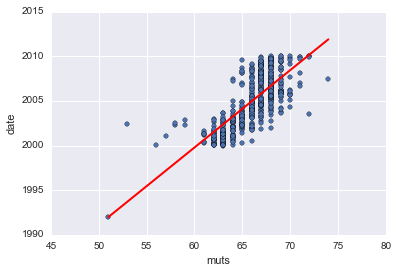

In [86]:
fig = plt.figure(figsize=(10, 10))
import statsmodels.formula.api as smf
import statsmodels.api as sm
temp = df[['muts', 'date']]
temp = temp.dropna()
lm = smf.ols(formula='date ~ muts', data=temp).fit()
lm.params
X_line = pd.DataFrame({'muts': [temp.muts.min(), temp.muts.max()]})
preds = lm.predict(X_line)
temp.plot(kind='scatter', x='muts', y='date')
#plot the least squares line
plt.plot(X_line, preds, c='red', linewidth=2)
print('R-squared = ' + str(lm.rsquared))
X_new = pd.DataFrame({'muts': list(df['muts'])}) 
X_new['pred'] = pd.Series(lm.predict(X_new), index=X_new.index)
df['pred'] = X_new['pred']


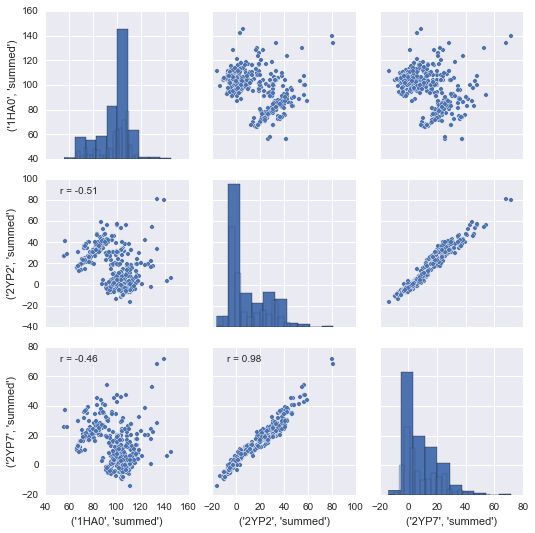

In [87]:
from scipy import stats
idx = pd.IndexSlice
df_summed = df.loc[idx[:], idx[:,'summed']]
p = sns.pairplot(df_summed)

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
p.map_lower(corrfunc)
p.map_diag(sns.distplot, kde=False)

## Correlation between sum_ddg and epistasis_ddg

In [88]:
if include_epistasis: 
    fig = plt.figure(figsize=(16, 5))
    plot = 131
    for structure in structures:
        temp = df[structure]
        plt.subplot(plot)
        p = sns.regplot(x='summed', y='epistasis', data=temp)
        #plt.scatter(temp.summed, temp.epistasis)
        axes = plt.gca()
        ymin, ymax = axes.get_ylim()
        xmin, xmax = axes.get_xlim()
        x = np.linspace(xmin.item(), xmax.item())
        y = np.linspace(xmin.item(), xmax.item())
        plt.plot(x, y)
        plt.title(structure)
        plt.xlabel('summed')
        plt.ylabel('epistasis')
        plot += 1
    plt.tight_layout()
    plt.show()

## ddG by Classification

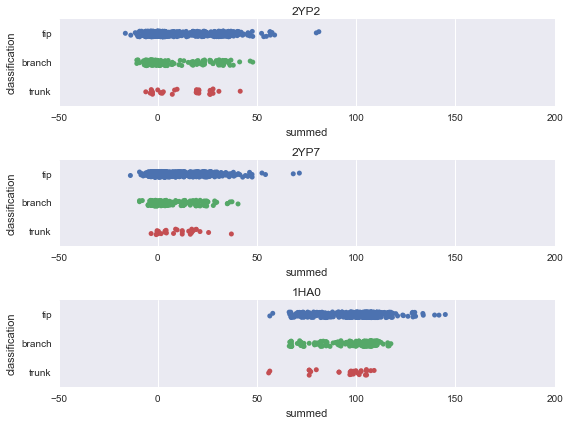

In [92]:
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(8, 6))
if include_epistasis:
    plot = 321
    for structure in structures:
        ax = plt.subplot(plot)
        temp = df[structure]
        sns.stripplot(x='summed', y='classification', data=temp, jitter=True)
        sns.plt.title(structure)
        plot += 1
        plt.subplot(plot)
        sns.stripplot(x='epistasis', y='classification', data=temp, jitter=True)
        sns.plt.title(structure)
        plot += 1
else: 
    plot = 311
    for structure in structures:
        ax = plt.subplot(plot)
        temp = df[structure]
        sns.stripplot(x='summed', y='classification', data=temp, jitter=True)
        sns.plt.title(structure)
        plot += 1
        ax.set_xlim([-50, 200])
plt.tight_layout()
plt.show()

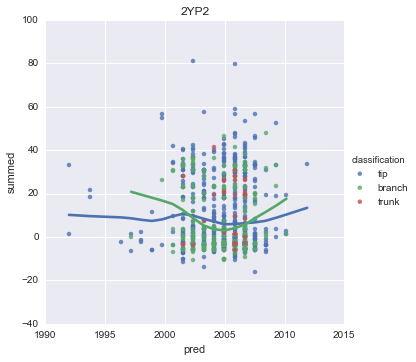

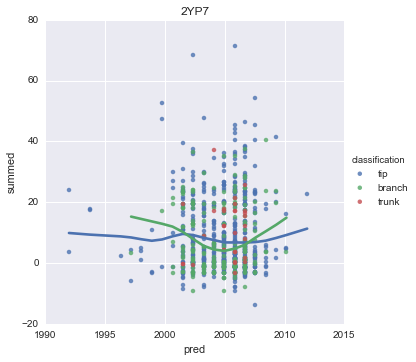

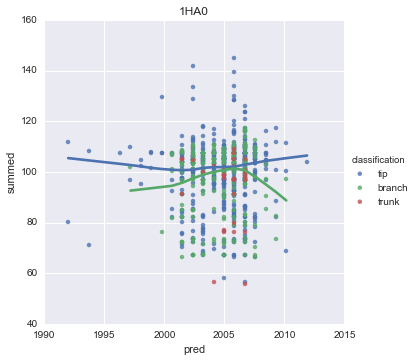

In [90]:
for structure in structures:
    temp = df[structure]
    temp['pred'] = df['pred']
    sns.lmplot("pred", "summed", hue="classification", data=temp, lowess=True)
    #sns.plt.xlim(1990, 2020)
    #sns.plt.ylim(-50, 150)
    sns.plt.title(structure)
    plt.show()


9272
9272
9272
[[ 179.41887615  199.04283252  162.83702882]
 [ 168.67130183  222.1301118   188.23918464]
 [ 222.15770165  217.16115713  217.95243167]
 [ 188.14806581  214.99030102  233.13735536]
 [ 227.06254753  172.68718323  188.47218028]
 [ 240.3993975   223.26259477  229.75670053]
 [ 212.764748    168.17923392  236.16516762]
 [ 195.72946604  234.04990585  189.31683328]
 [ 237.45596584  202.64314062  202.30091839]
 [ 196.00609582  172.79498104  199.33517231]]


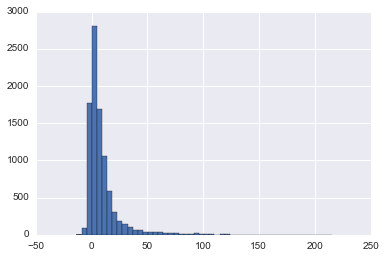

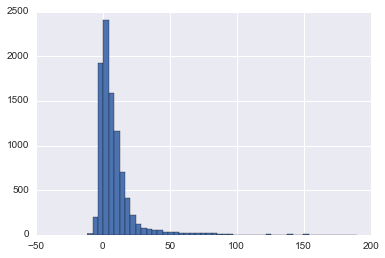

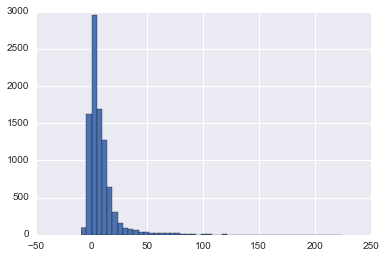

In [91]:
file_1HA0 = open("0_1HA0_sequences_ddg.txt", 'r')
file_2YP7 = open("0_2YP7_sequences_ddg.txt", 'r')
file_2YP2 = open("0_2YP2_sequences_ddg.txt", 'r')
files = [file_1HA0, file_2YP7, file_2YP2]
dics = []
gaussian_numbers = np.random.randn(1000)
for file in files:
    ddgs = []
    plt.figure()
    for line in file:
        split_line = line.split()
        site = int(split_line[1][1:len(split_line[1]) - 1])
        ddg = float(split_line[0])
        ddgs.append(ddg)
    print(len(ddgs))
    plt.hist(ddgs, 50)
mu, sigma = 200, 25
x = mu + sigma*scipy.randn(10,3)    
print(x)